# Numerics for the SYK quantum batteries

let us start by including the relevant packages

In [1]:
include("/home/dario/Documents/ChargingPower/src/ChargingPower.jl")
using .ChargingPower

In [2]:
using SparseArrays
using KrylovKit
using ExponentialUtilities
using Graphs
using Plots
using Statistics
using SpecialFunctions
using QuadGK
using Plots
using DelimitedFiles

and let us set the parameters for the time evolution

In [3]:
min_t = 10^-2 
max_t = 10^2
number_of_points = 10^3
points = exp.(log(min_t):((log(max_t) - log(min_t)) / (number_of_points - 1)):log(max_t))

999-element Vector{Float64}:
  0.010000000000000004
  0.010092621909870477
  0.010186101701559765
  0.0102804473209331
  0.01037566678745186
  0.010471768194855211
  0.010568759711848048
  0.010666649582795396
  0.010765446128423155
  0.010865157746525389
  ⋮
 92.03731996618232
 92.889787201645
 93.75015015145291
 94.6184819472201
 95.49485639791966
 96.37934799615793
 97.27203192450553
 98.17298406188837
 99.08228099003803

## The Z-model charging power

Let us start with the Z-model battery

In [4]:
n_majorana = 28
samples_done = 0
average_energy_list = zeros(Float64, length(points))
e_0 = -n_majorana /2

-14.0

In [ ]:
n_samples = 10
energy_single_size_list = Array{Float64}[] 
majorana_matrices = majorana_operators(n_majorana)
graph = complete_graph(n_majorana)
battery_hamiltonian = Z_model_hamiltonian(majorana_matrices)
for i in 1:n_samples 
    charging_hamiltonian = SYK_hamiltonian(majorana_matrices, graph)
    ground_state_rough = eigsolve(battery_hamiltonian, rand(ComplexF64, floor(Int, 2^(n_majorana/2))), 1, :SR)
    ground_state = ground_state_rough[2][1]
    energy_list = Float64[]
    for index in eachindex(points) 
        if index == 1
            ground_state = expv(- im * points[index], charging_hamiltonian, ground_state)
        else
            ground_state = expv(- im * (points[index] - points[index-1]), charging_hamiltonian, ground_state)
        end
        push!(energy_list, (real(ground_state' * battery_hamiltonian * ground_state)))
    end
    push!(energy_single_size_list, energy_list)
end
average_energy_list = (samples_done .* average_energy_list + n_samples * mean(energy_single_size_list)) / (samples_done + n_samples)
samples_done += n_samples
samples_done

In [19]:
theoretical_points = [-1 * (n_majorana/2) * (besselj(1, 2* t) / t)^2 for t in points]
average_power_list = [((average_energy_list[index] - e_0))/(points[index]) for index in 1:length(points)]
theoretical_power_points = [((theoretical_points[index] - e_0))/(points[index]) for index in 1:length(points)]

999-element Vector{Float64}:
 0.13999416680245952
 0.14129070995291115
 0.14259925886127028
 0.14391992464058406
 0.14525281943167356
 0.1465980564101739
 0.14795574979872445
 0.14932601487489314
 0.15070896798062178
 0.15210472653332596
 ⋮
 0.1521121601995235
 0.15071623845762808
 0.1493330389267199
 0.1479626358677954
 0.14660470218289204
 0.14525932934229194
 0.14392622643258318
 0.14260539991414287
 0.14129669454515598

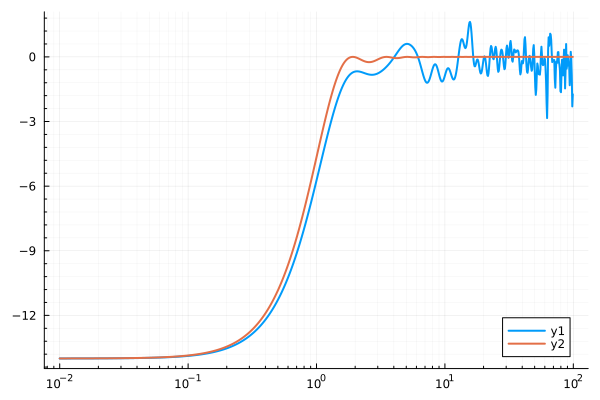

In [20]:
plot(points, [average_energy_list, theoretical_points], xaxis=:log, linewidth=2, minorgrid=true)   

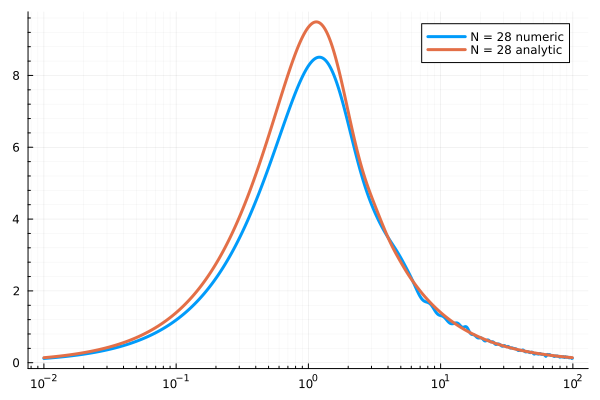

In [ ]:
graph = plot(points, [average_power_list, theoretical_power_points], xaxis=:log, linewidth=3, minorgrid=true, label = ["N = 28 numerical" "N = 28 analytical"], legendfontsize=8) 

In [ ]:
savefig(graph, "/home/dario/Documents/ChargingPower/plots_power/N28_Z-model_19_samples.pdf")


"/home/dario/Documents/ChargingPower/plots_power/N28_X-model_19_samples.pdf"

In [ ]:
open("/home/dario/Documents/ChargingPower/data_power/N28_Z-model_19_samples_points.txt", "w") do io
    writedlm(io, points, ',')
end;
open("/home/dario/Documents/ChargingPower/data_power/N28_Z-model_19_samples_power.txt", "w") do io
    writedlm(io, average_power_list, ',')
end;

## The X-model charging power

Let us now collect the data for the X-model battery

In [4]:
n_majorana = 28
samples_done = 0
average_energy_list = zeros(Float64, length(points))
e_0 = -n_majorana /2

-14.0

In [29]:
n_samples = 9
energy_single_size_list = Array{Float64}[] 
majorana_matrices = majorana_operators(n_majorana)
graph = complete_graph(n_majorana)
battery_hamiltonian = X_model_hamiltonian(majorana_matrices)
for i in 1:n_samples 
    charging_hamiltonian = SYK_hamiltonian(majorana_matrices, graph)
    ground_state_rough = eigsolve(battery_hamiltonian, rand(ComplexF64, floor(Int, 2^(n_majorana/2))), 1, :SR)
    e_0 = real(ground_state_rough[1][1])
    ground_state = ground_state_rough[2][1]
    energy_list = Float64[]
    for index in eachindex(points) 
        if index == 1
            ground_state = expv(- im * points[index], charging_hamiltonian, ground_state)
        else
            ground_state = expv(- im * (points[index] - points[index-1]), charging_hamiltonian, ground_state)
        end
        push!(energy_list, (real(ground_state' * battery_hamiltonian * ground_state)))
    end
    push!(energy_single_size_list, energy_list)
end
average_energy_list = (samples_done .* average_energy_list + n_samples * mean(energy_single_size_list)) / (samples_done + n_samples)
samples_done += n_samples
samples_done


19

In [30]:
theoretical_points = Float64[]
for t in points
    sum = 0.0 
    for k in 1:floor(Int, n_majorana/2)
        sum += (besselj(1, 2 * t * sqrt(1 - (2 * k - 1)/n_majorana)) / (t * sqrt(1 - (2 * k - 1)/n_majorana)))^(2 * k - 1)
    end
    push!(theoretical_points,  - 1 * sum)
end
average_power_list = [((average_energy_list[index] - e_0))/(points[index]) for index in 1:length(points)]
theoretical_power_points = [((theoretical_points[index] - e_0))/(points[index]) for index in 1:length(points)]
theoretical_power_approx_points = Float64[]
for t in points
    f(x) = exp(-n_majorana/2 * t^2 * x * (1 - x))
    f_value = quadgk(f, 0, 1, rtol=1e-3)[1]
    push!(theoretical_power_approx_points,  (n_majorana / (2 * t)) * (1 - f_value))
end

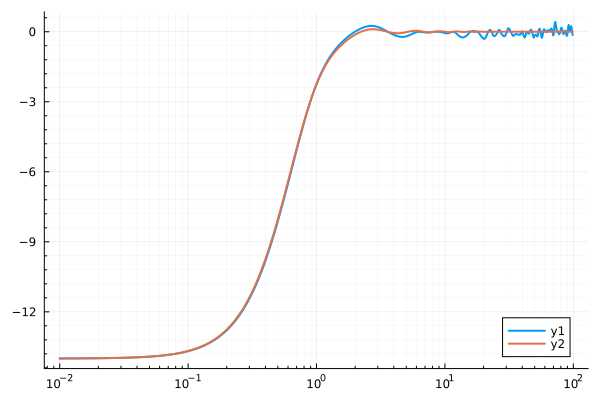

In [31]:
plot(points, [average_energy_list, theoretical_points], xaxis=:log, linewidth=2, minorgrid=true)   

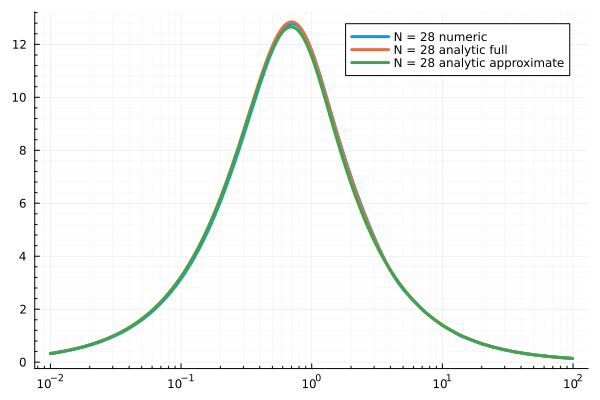

In [42]:
graph = plot(points, [average_power_list, theoretical_power_points, theoretical_power_approx_points], xaxis=:log, linewidth=3, minorgrid=true, label = ["N = 28 numeric" "N = 28 analytic full" "N = 28 analytic approximate"], legendfontsize=8) 

In [44]:
savefig(graph, "/home/dario/Documents/ChargingPower/plots_power/N28_X-model_19_samples.pdf")


"/home/dario/Documents/ChargingPower/plots_power/N28_X-model_19_samples.pdf"

In [47]:
open("/home/dario/Documents/ChargingPower/data_power/N28_X-model_19_samples_points.txt", "w") do io
    writedlm(io, points, ',')
end;
open("/home/dario/Documents/ChargingPower/data_power/N28_X-model_19_samples_power.txt", "w") do io
    writedlm(io, average_power_list, ',')
end;